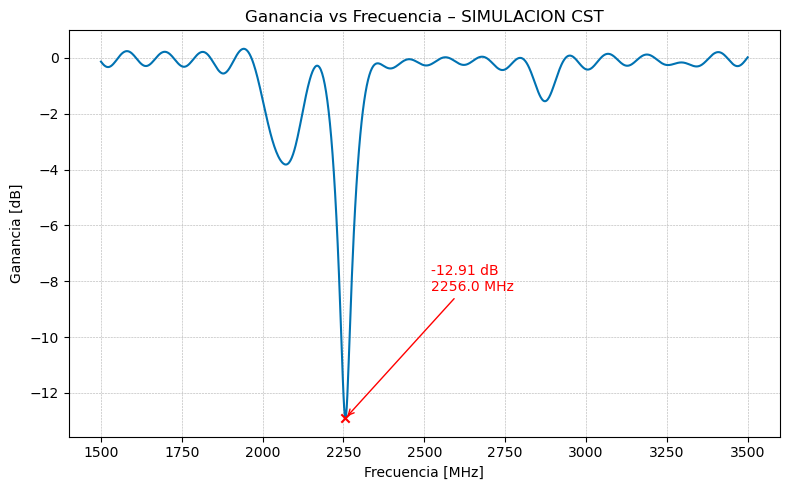

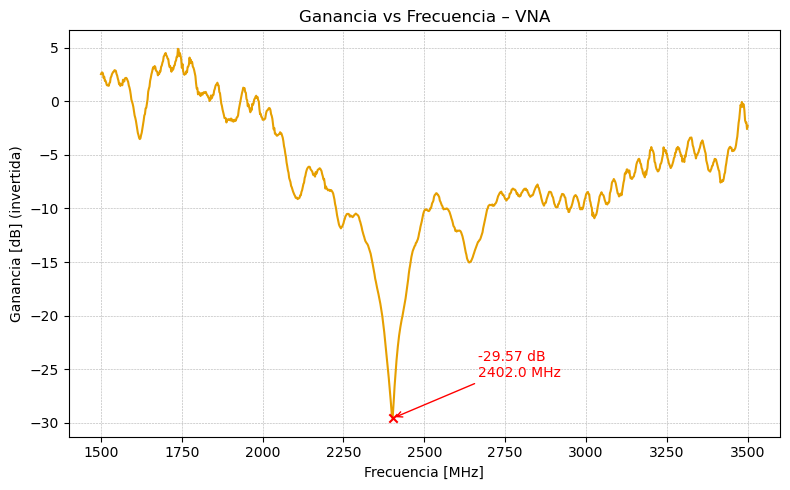

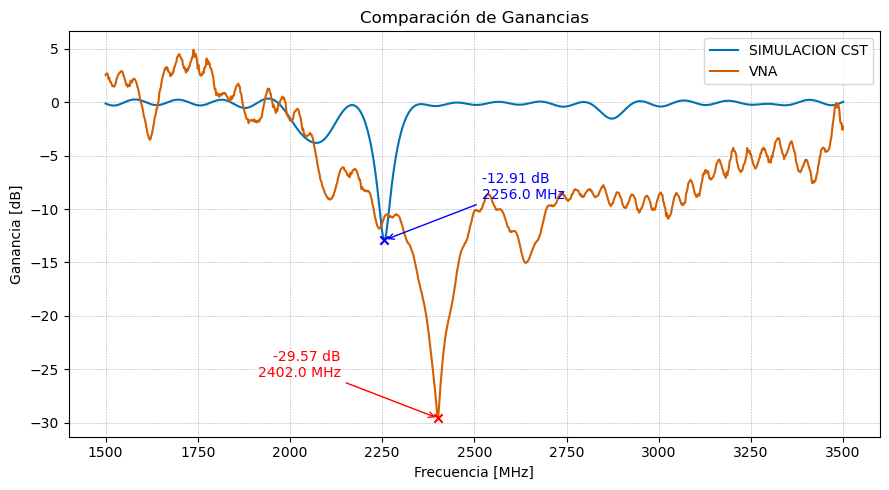

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# 1. Rutas de los archivos
# -------------------------------------------------------------------------

CST_PATH  = "D:\Facultad\Electromagnetismo_2\Antena_Patch\Antena_Patch_2.4GHz_2x2\Resultados Antena/CST_mag_phase.txt"          # Archivo directo del export del CST (.txt)
MATP_PATH = "D:\Facultad\Electromagnetismo_2\Antena_Patch\Antena_Patch_2.4GHz_2x2\Resultados Antena/MATP_LOG_CSV (2).csv"       # Archivo directo del export del VNA (.csv)

# -------------------------------------------------------------------------
# 2. Carga y procesado del archivo CST (txt con tabuladores)
#    Columnas: frecuencia [MHz] – magnitud lineal
# -------------------------------------------------------------------------
freq_cst, mag_cst = [], []
with open(CST_PATH) as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith(("#", '"', "{")):
            continue
        f_mhz, m_lin = line.split("\t")[:2]
        freq_cst.append(float(f_mhz))
        mag_cst.append(float(m_lin))

df_cst = pd.DataFrame({"Frequency_MHz": freq_cst, "Mag": mag_cst})
df_cst["Gain_dB"] = 20 * np.log10(df_cst["Mag"])

# -------------------------------------------------------------------------
# 3. Carga y procesado del archivo MATP (csv tipo VNA)
#    – Bloque de datos entre BEGIN / END
#    – Frecuencia en Hz → se pasa a MHz
#    – La magnitud lineal se convierte a dB y se invierte el signo
# -------------------------------------------------------------------------
freq_matp, mag_matp, inside = [], [], False
with open(MATP_PATH) as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("!"):
            continue
        if line == "BEGIN": inside = True;  continue
        if line == "END":   break
        if inside:
            f_hz, m_lin = line.split(",")[:2]
            freq_matp.append(float(f_hz)/1e6)          # Hz → MHz
            mag_matp.append(float(m_lin))

df_matp = pd.DataFrame({"Frequency_MHz": freq_matp, "Mag": mag_matp})
df_matp["Gain_dB"] = -20 * np.log10(df_matp["Mag"])   # signo invertido

# -------------------------------------------------------------------------
# 4. Identificación automática de los mínimos
# -------------------------------------------------------------------------
idx_min_cst  = df_cst["Gain_dB"].idxmin()
fmin_cst     = df_cst.at[idx_min_cst, "Frequency_MHz"]
gmin_cst     = df_cst.at[idx_min_cst, "Gain_dB"]

idx_min_matp = df_matp["Gain_dB"].idxmin()
fmin_matp    = df_matp.at[idx_min_matp, "Frequency_MHz"]
gmin_matp    = df_matp.at[idx_min_matp, "Gain_dB"]

# -------------------------------------------------------------------------
# 5. Función auxiliar para colocar anotaciones de manera legible
# -------------------------------------------------------------------------
def annotate_min(ax, x, y, *, color="black", other_x=None):
    """
    Añade un texto + flecha indicando el punto (x, y) con desplazamiento
    automático para evitar solapamiento.

    Parámetros
    ----------
    ax : matplotlib.axes.Axes
        Eje sobre el cual anotar.
    x, y : float
        Coordenadas del punto mínimo.
    color : str
        Color del texto, flecha y marcador.
    other_x : float | None
        Segunda abscisa “crítica” para decidir la dirección de desplazamiento
        cuando hay dos mínimos en la misma gráfica comparativa.
    """
    # Límites horizontales actuales
    x_left, x_right = ax.get_xlim()
    span = x_right - x_left

    # Desplazamiento horizontal adaptativo
    if x > x_left + 0.66*span:
        dx, ha = -0.10*span, "right"     # extremo derecho → texto a la izquierda
    elif x < x_left + 0.33*span:
        dx, ha =  0.10*span, "left"      # extremo izquierdo → texto a la derecha
    else:
        # zona central → aleja del otro mínimo si existe
        dx  =  0.12*span if (other_x is None or x < other_x) else -0.12*span
        ha  = "left"  if dx > 0 else "right"

    # Desplazamiento vertical
    dy = 5 if y < -10 else -5

    # Marcador
    ax.scatter(x, y, color=color, marker="x", zorder=5)

    # Texto y flecha
    ax.annotate(f"{y:.2f} dB\n{x:.1f} MHz",
                xy=(x, y),
                xytext=(x+dx, y+dy),
                color=color,
                ha=ha,
                va="center",
                arrowprops=dict(arrowstyle="->", color=color, lw=1.0))

# -------------------------------------------------------------------------
# 6. Gráfica individual: CST
# -------------------------------------------------------------------------
plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.plot(df_cst["Frequency_MHz"], df_cst["Gain_dB"], color="#0072B2")
annotate_min(ax, fmin_cst, gmin_cst, color="red")
ax.set_title("Ganancia vs Frecuencia – SIMULACION CST")
ax.set_xlabel("Frecuencia [MHz]")
ax.set_ylabel("Ganancia [dB]")
ax.grid(True, linestyle="--", linewidth=0.4)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 7. Gráfica individual: MATP
# -------------------------------------------------------------------------
plt.figure(figsize=(8, 5))
ax = plt.gca()
ax.plot(df_matp["Frequency_MHz"], df_matp["Gain_dB"], color="#E69F00")
annotate_min(ax, fmin_matp, gmin_matp, color="red")
ax.set_title("Ganancia vs Frecuencia – VNA")
ax.set_xlabel("Frecuencia [MHz]")
ax.set_ylabel("Ganancia [dB] (invertida)")
ax.grid(True, linestyle="--", linewidth=0.4)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 8. Gráfica comparativa
# -------------------------------------------------------------------------
plt.figure(figsize=(9, 5))
ax = plt.gca()
ax.plot(df_cst["Frequency_MHz"], df_cst["Gain_dB"],
        label="SIMULACION CST", color="#0072B2")
ax.plot(df_matp["Frequency_MHz"], df_matp["Gain_dB"],
        label="VNA", color="#D55E00")
annotate_min(ax, fmin_cst,  gmin_cst,  color="blue", other_x=fmin_matp)
annotate_min(ax, fmin_matp, gmin_matp, color="red",  other_x=fmin_cst)
ax.set_title("Comparación de Ganancias")
ax.set_xlabel("Frecuencia [MHz]")
ax.set_ylabel("Ganancia [dB]")
ax.legend()
ax.grid(True, linestyle="--", linewidth=0.4)
plt.tight_layout()
plt.show()
